In [1]:
import torch
from byol_pytorch import BYOL
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
warnings.filterwarnings("ignore")

# Set parameters
bird_dir = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Canary_Data/llb3/'
audio_files = bird_dir+'llb3_songs'
directory = bird_dir+ 'llb3_data_matrices/Python_Files'
analysis_path = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis'

# Parameters we set
num_spec = 1
window_size = 100
stride = 10

# Define the folder name
folder_name = f'{analysis_path}/Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_name+"/Plots/Window_Plots"):
    os.makedirs(folder_name+"/Plots/Window_Plots")
    print(f'Folder "{folder_name}" created successfully.')
else:
    print(f'Folder "{folder_name}" already exists.')



# In[15]:


if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  


Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis/Num_Spectrograms_1_Window_Size_100_Stride_10" already exists.


In [3]:
device

'cuda:0'

In [4]:
# =============================================================================
# # If you are loading the results from a previous analysis, run the following lines of code
# =============================================================================

stacked_windows = np.load(folder_name+'/stacked_windows.npy') # An array of all the mini-spectrograms
labels_for_window = np.load(folder_name+'/labels_for_window.npy') # The syllable labels for each time point in each mini-spectrogram
embedding = np.load(folder_name+'/UMAP_Embedding.npy') # The pre-computed UMAP embedding (2 dimensional)
masked_frequencies = np.load(analysis_path+'/masked_frequencies_lowthresh_500_highthresh_7000.npy') # The frequencies we want to use for analysis. Excluding unnecessarily low and high frequencies
stacked_window_times = np.load(folder_name+'/stacked_window_times.npy') # The onsets and ending of each mini-spectrogram
    
# open the file for reading in binary mode
with open(folder_name+'/category_colors.pkl', 'rb') as f:
    # load the dictionary from the file using pickle.load()
    category_colors = pickle.load(f)   
    
# Each syllable is given a unique color. Each mini-spectrogram will have an average syllable color associated with it. This is the average RGB value across all unique syllables in the mini-spectrogram
mean_colors_per_minispec = np.load(folder_name+'/mean_colors_per_minispec.npy')



In [6]:
batch_size = 20
num_batches = int(stacked_windows.shape[0]/batch_size)
height = stacked_window_times.shape[1]
width = int(stacked_windows.shape[1]/height)
image_size = 151

from torch.utils.data import DataLoader

# Define a PyTorch dataset
my_dataloader = DataLoader(stacked_windows, batch_size = batch_size)

# Iterate over the data in batches
batch_sizes_list = []
for batch in my_dataloader:
    # Process the batch of data
    batch_sizes_list.append(batch.shape[0])
    print(batch.shape)
    
my_dict = {}
for idx, batch in enumerate(my_dataloader):
    key = idx
    value = batch 
    value = value.reshape(value.shape[0], 1, window_size, width)
    new_size = (image_size, image_size)  # replace with your desired size
    resized_tensor = F.interpolate(value, size=new_size, mode='bilinear', align_corners=False)
    new_tensor = resized_tensor.repeat(1, 3, 1, 1)
    my_dict[idx] = new_tensor

stacked_windows_3d = np.vstack([value for key, value in my_dict.items()])

# stacked_windows_3d = torch.zeros(len(batch_sizes_list, ))
    
# x = stacked_windows[0:157,:]
# input_torch = x.reshape(batch_size, 1, height, width)
# input_torch = stacked_windows.reshape(num_batches, batch_size, 1, height, width)
# input_torch = torch.tensor(input_torch).float()
# input_torch.shape


# In[20]:


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16*75*75, 2)

    def forward(self, x):
        x = x.float().to(device)
        x = self.conv(x)
        # x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x.float())
        return x
    
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.relu = nn.ReLU()
        self.fc = nn.Linear(18944, 2)

    def forward(self, x):
        x = x.float().to(device)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x.float())
        return x


# %% Creating the custom transformation function

class augmentations(nn.Module):
    def __init__(self, stacked_windows_3d, my_dict, window_length, frequency_length, image_size):
        super(augmentations, self).__init__()
        self.stacked_windows_3d = stacked_windows_3d
        self.dict_of_stacked_windows = my_dict
        self.window_length = window_length
        self.frequency_length = frequency_length
        self.image_size = image_size
        self.batch_size = batch_size
    
    
    def augment_fn(self, x):
        
        try: 
            x_smaller = x[:,0,:,:]
            x_smaller = x_smaller.reshape(x_smaller.shape[0], x_smaller.shape[1]*x_smaller.shape[2])
            stacked_windows_smaller = self.stacked_windows_3d
            stacked_windows_smaller = stacked_windows_smaller[:,0,:,:]
            stacked_windows_smaller = stacked_windows_smaller.reshape(stacked_windows_smaller.shape[0], stacked_windows_smaller.shape[1]*stacked_windows_smaller.shape[2])
            res = (stacked_windows_smaller[:, None] == x_smaller).all(-1).any(-1)
            torch_intersecting_rows = torch.nonzero(torch.tensor(res))
            torch_intersecting_rows = torch_intersecting_rows.reshape(torch_intersecting_rows.size(0),).numpy()
            new_tensor = stacked_windows_3d[torch_intersecting_rows+1, :,:,:]
            return new_tensor
        
        except Exception as E:
            dummyDat = torch.randn(x.size(0), 3, self.image_size, self.image_size)
            dummyDat = dummyDat.to(device)
            return dummyDat
            
        
        
        
        
        
        # try: 
            
        # for i in range(len(my_dict)):
        #     batch_to_check = my_dict[i]
            
        #     x_smaller = x[:,0,:,:]
        #     x_smaller = x_smaller.reshape(x_smaller.shape[0], x_smaller.shape[1]*x_smaller.shape[2])
        #     batch_to_check_smaller = batch_to_check[:,0,:,:]
        #     batch_to_check_smaller = batch_to_check_smaller.reshape(batch_to_check_smaller.shape[0], batch_to_check_smaller.shape[1]*batch_to_check_smaller.shape[2])

        #     res = (batch_to_check_smaller[:, None] == x_smaller).all(-1).any(-1)
        #     torch_intersecting_rows = torch.nonzero(res)
        #     torch_intersecting_rows = torch_intersecting_rows.reshape(torch_intersecting_rows.size(0),).numpy()
        #     if torch_intersecting_rows.size ==0:
        #         dummyData = torch.randn(self.batch_size, 1, self.window_length, self.frequency_length)
        #         new_size = (self.image_size, self.image_size)  # replace with your desired size
        #         resized_tensor = F.interpolate(dummyData, size=new_size, mode='bilinear', align_corners=False)
        #         new_tensor = resized_tensor.repeat(1, 3, 1, 1)
        #     else:
        #         new_tensor = batch_to_check[torch_intersecting_rows+1, :,:,:]
        #         break
        
        # return new_tensor
            
            
        #     # condition_check = (x[:, None, :] == self.stacked_windows)
        #     # intersection = torch.where((x[:, None, :] == self.stacked_windows).all(dim=2))[0]
            
        #     spec_to_return = self.stacked_windows[intersection+1, :]
        #     spec_to_return = spec_to_return.reshape(spec_to_return.shape[0], 1, self.window_length, self.frequency_length)
            
        #     new_size = (self.image_size, self.image_size)  # replace with your desired size
        #     resized_tensor = F.interpolate(spec_to_return, size=new_size, mode='bilinear', align_corners=False)

        #     # Print the shape of the resized tensor
        #     # print(resized_tensor.shape)

        #     # extract the first dimension of the tensor
        #     first_dim = resized_tensor.shape[0]

        #     # create a new tensor by repeating the original tensor along the new dimensions
        #     new_tensor = resized_tensor.repeat(1, 3, 1, 1)
            
            
        #     return new_tensor
        
        # except Exception as E:
        #     # print('Encourntered issue',E)
        #     dummyDat = torch.randn(self.batch_size, 1, self.window_length, self.frequency_length)
        #     new_size = (self.image_size, self.image_size)  # replace with your desired size
        #     resized_tensor = F.interpolate(dummyDat, size=new_size, mode='bilinear', align_corners=False)

        #     # Print the shape of the resized tensor
        #     # print(resized_tensor.shape)

        #     # extract the first dimension of the tensor
        #     first_dim = resized_tensor.shape[0]

        #     # create a new tensor by repeating the original tensor along the new dimensions
        #     new_tensor = resized_tensor.repeat(1, 3, 1, 1)
        #     return new_tensor
        
        # condition_check = (x[:, None, :] == self.stacked_windows)
        # if condition_check == False: 
            # continue
        # else:
        # intersection = torch.where((x[:, None, :] == self.stacked_windows).all(dim=2))[0]
        # return self.stacked_windows[intersection+1, :]
    
    def augment_fn2(self, x):
        
        try: 
            x_smaller = x[:,0,:,:]
            x_smaller = x_smaller.reshape(x_smaller.shape[0], x_smaller.shape[1]*x_smaller.shape[2])
            stacked_windows_smaller = self.stacked_windows_3d
            stacked_windows_smaller = stacked_windows_smaller[:,0,:,:]
            stacked_windows_smaller = stacked_windows_smaller.reshape(stacked_windows_smaller.shape[0], stacked_windows_smaller.shape[1]*stacked_windows_smaller.shape[2])
            res = (stacked_windows_smaller[:, None] == x_smaller).all(-1).any(-1)
            torch_intersecting_rows = torch.nonzero(torch.tensor(res))
            torch_intersecting_rows = torch_intersecting_rows.reshape(torch_intersecting_rows.size(0),).numpy()
            new_tensor = stacked_windows_3d[torch_intersecting_rows+2, :,:,:]
            return new_tensor
        
        except Exception as E:
            dummyDat = torch.randn(x.size(0), 3, self.image_size, self.image_size)
            dummyDat = dummyDat.to(device)
            return dummyDat

        # condition_check = (x[:, None, :] == self.stacked_windows)
        # if condition_check == False: 
            # continue
        # else:
        # intersection = torch.where((x[:, None, :] == self.stacked_windows).all(dim=2))[0]
        # return self.stacked_windows[intersection+2, :]
        
# def augment_fn(x, stacked_windows):
#     # Find the intersection of the input spectrogram and the stacked_windows to see which row index (spectrogram number) we are at
#     # intersection = torch.eq(torch.tensor(x), torch.tensor(stacked_windows))
#     intersection = torch.where((x[:, None, :] == stacked_windows).all(dim=2))[0]
    
#     return stacked_windows[intersection+1, :]

# def augment_fn2(x, stacked_windows):
#     # Find the intersection of the input spectrogram and the stacked_windows to see which row index (spectrogram number) we are at
#     # intersection = torch.eq(torch.tensor(x), torch.tensor(stacked_windows))
#     intersection = torch.where((x[:, None, :] == stacked_windows).all(dim=2))[0]
    
#     return stacked_windows[intersection+2, :]







# In[21]:

# resnet = models.resnet50(pretrained=True)
# model = SimpleCNN()
model = TweetyNetCNN()
model = model.to(device)
augmentations = augmentations(stacked_windows_3d, my_dict, window_size, width, 151 )

augment_fn = augmentations.augment_fn
augment_fn2 = augmentations.augment_fn2
# resnet = resnet.to(device)
learner = BYOL( 
    model,
    image_size = 151,
    projection_size = 2,           # the projection size
    projection_hidden_size = 100,   # the hidden dimension of the MLP for both the projection and prediction
    augment_fn = augment_fn,
    augment_fn2 = augment_fn2
)
# learner = BYOL( 
#     model,
#     image_size = 151,
#     projection_size = 2,           # the projection size
#     projection_hidden_size = 100   # the hidden dimension of the MLP for both the projection and prediction
# )
learner = learner.to(device)

torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([20, 15100])
torch.Size([8, 15100])


RuntimeError: Given groups=1, weight of size [64, 3, 5, 5], expected input[2, 32, 18, 149] to have 3 channels, but got 32 channels instead

In [56]:
device

'cuda:0'

Epoch 0, Mean Batch Loss: 0.57
Epoch 1, Mean Batch Loss: 1.42
Epoch 2, Mean Batch Loss: 1.08
Epoch 3, Mean Batch Loss: 0.60
Epoch 4, Mean Batch Loss: 0.95
Epoch 5, Mean Batch Loss: 0.41
Epoch 6, Mean Batch Loss: 0.55
Epoch 7, Mean Batch Loss: 0.83
Epoch 8, Mean Batch Loss: 0.60
Epoch 9, Mean Batch Loss: 0.42
Epoch 10, Mean Batch Loss: 0.56
Epoch 11, Mean Batch Loss: 0.89
Epoch 12, Mean Batch Loss: 0.54
Epoch 13, Mean Batch Loss: 0.70
Epoch 14, Mean Batch Loss: 0.98
Epoch 15, Mean Batch Loss: 0.63
Epoch 16, Mean Batch Loss: 0.89
Epoch 17, Mean Batch Loss: 0.44
Epoch 18, Mean Batch Loss: 0.24
Epoch 19, Mean Batch Loss: 0.97
Epoch 20, Mean Batch Loss: 0.36
Epoch 21, Mean Batch Loss: 0.75
Epoch 22, Mean Batch Loss: 1.17
Epoch 23, Mean Batch Loss: 0.79
Epoch 24, Mean Batch Loss: 0.67
Epoch 25, Mean Batch Loss: 0.98
Epoch 26, Mean Batch Loss: 0.31
Epoch 27, Mean Batch Loss: 0.40
Epoch 28, Mean Batch Loss: 0.67
Epoch 29, Mean Batch Loss: 0.82
Epoch 30, Mean Batch Loss: 0.95
Epoch 31, Mean Bat

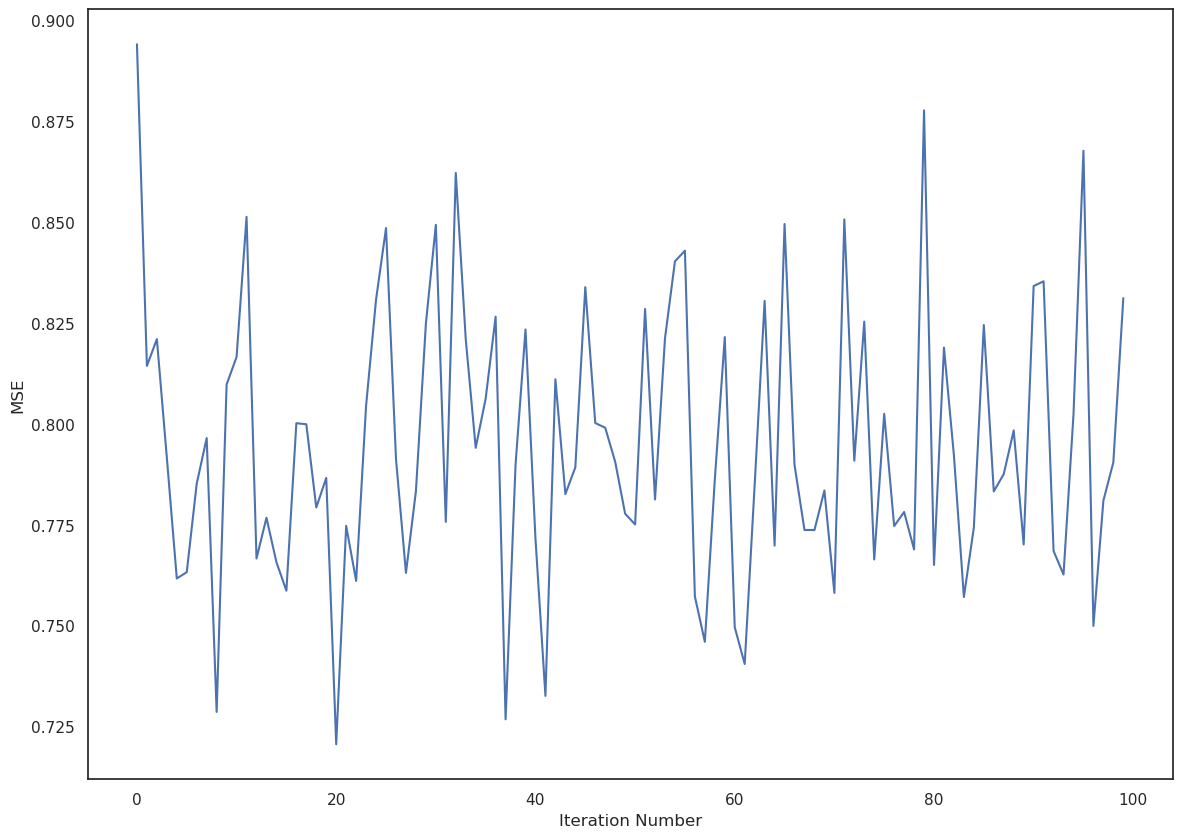

'/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis/Num_Spectrograms_1_Window_Size_100_Stride_10/Plots/byol.html'

In [57]:
num_epochs = 100

opt = torch.optim.Adam(learner.parameters(), lr=0.01)
loss_list = []
for i in range(num_epochs):
    batch_loss = []
    
    for b in range(len(my_dict)):
        batch_data = my_dict[b]
    
    # for batch_index, batch_data in enumerate(my_dataloader):
        # print(f'Batch Number: {batch_index}')
        # Extract the batch 
        input_torch_batch = batch_data.to(device)

        # Resize images to be square. Also make the images compatible with BYOL package by adding in 3 channels
        # new_size = (151, 151)  # replace with your desired size
        # resized_tensor = F.interpolate(input_torch_batch, size=new_size, mode='bilinear', align_corners=False)

        # # Print the shape of the resized tensor
        # # print(resized_tensor.shape)

        # # extract the first dimension of the tensor
        # first_dim = resized_tensor.shape[0]

        # # create a new tensor by repeating the original tensor along the new dimensions
        # new_tensor = resized_tensor.repeat(1, 3, 1, 1)
        loss = learner(input_torch_batch, return_embedding = False, return_projection = True)
        batch_loss.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()

    loss_list.append(np.mean(batch_loss))
    if i%1 == 0:
        print(f'Epoch {i}, Mean Batch Loss: {loss.item():.2f}')


# In[23]:


projection_arr = []
embedding_arr = []
with torch.no_grad():
    for b in range(len(my_dict)):
        batch_data = my_dict[b]
    # for batch_index, batch_data in enumerate(my_dataloader):
        # print(f'Batch Number: {batch_index}')
        # Extract the batch 
        input_torch_batch = batch_data.to(device)
        
        # spec_to_return = input_torch_batch.reshape(input_torch_batch.shape[0], 1, window_size, width)
        
        # new_size = (image_size, image_size)  # replace with your desired size
        # resized_tensor = F.interpolate(spec_to_return, size=new_size, mode='bilinear', align_corners=False)
        
        # # Print the shape of the resized tensor
        # # print(resized_tensor.shape)
        
        # # extract the first dimension of the tensor
        # first_dim = resized_tensor.shape[0]
        
        # # create a new tensor by repeating the original tensor along the new dimensions
        # new_tensor = resized_tensor.repeat(1, 3, 1, 1)
        
        projection, embedding = learner(input_torch_batch, return_embedding = True, return_projection = True)
        projection_arr.append(projection.cpu().detach().numpy())
        embedding_arr.append(embedding.cpu().detach().numpy())


# In[24]:


projection_arr = np.concatenate(projection_arr, axis = 0)
embedding_arr = np.concatenate(embedding_arr, axis = 0)
print(projection_arr.shape)
print(embedding_arr.shape)


# In[25]:


plt.figure()
plt.plot(loss_list)
plt.xlabel("Iteration Number")
plt.ylabel("MSE")
plt.show()


# In[26]:


# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{folder_name}/Plots/byol.html')

# projection_arr = projection.clone().detach().numpy()

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(projection_arr, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = projection_arr[:,0], y = projection_arr[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

show(p)

save(p)


In [58]:
import umap
reducer = umap.UMAP()
embedding_after_umap = reducer.fit_transform(embedding_arr)

In [59]:
# Convert the UMAP embedding to a Pandas Dataframe
embedding_after_umap_df = pd.DataFrame(embedding_after_umap, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding_after_umap[:,0], y = embedding_after_umap[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

show(p)


In [47]:
embedding_after_umap_df.shape

(628, 2)